## E01 : Search Algorithms in Maze Setup

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from classes.Stack import Stack
from classes.Queue import Queue
from typing import Union
import pandas as pd
import numpy as np
import glob

**E1.01 :** Manually solve the following maze

<img src='imgs/e1.01_maze.png' alt='Maze' width='200' height='auto'>
<img src='imgs/e1.01_solved.png' alt='Solved Maze' width='200' height='auto'>

**E1.02 :** Read `maze_0x.csv` files and display information visually

In [2]:
# Maps 0 | 1 | 2 values into White, Gray and Orange, respectively
cmap = ListedColormap(['white', 'gray', 'orange'])
maze_path = 'datasets/*.csv'
maze_dict = {}

csv_files = enumerate(glob.glob(maze_path))
for file_path in csv_files:
    var_name = file_path[1].split('/')[1].split('.')[0]
    maze_dict[var_name] = pd.read_csv(file_path[1], header=None).to_numpy()

In [3]:
def maze_plotter(data: np.ndarray):
    """
    A helper function to plot 2D data into a maze
    """
    im = plt.imshow(data[::], interpolation='none', vmin=0, vmax=2, aspect='equal', cmap=cmap)

    # Get the axis
    ax=plt.gca()                            

    # Major ticks
    ax.set_xticks(np.arange(0, data.shape[1], 1))
    ax.set_yticks(np.arange(0, data.shape[0], 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, data.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, data.shape[0], 1), minor=True)

    # Invert the axis
    ax.set_ylim(ax.get_ylim()[::])  
    ax.set_xlim(ax.get_xlim()[::])      
    ax.xaxis.tick_top()                         

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
    return im

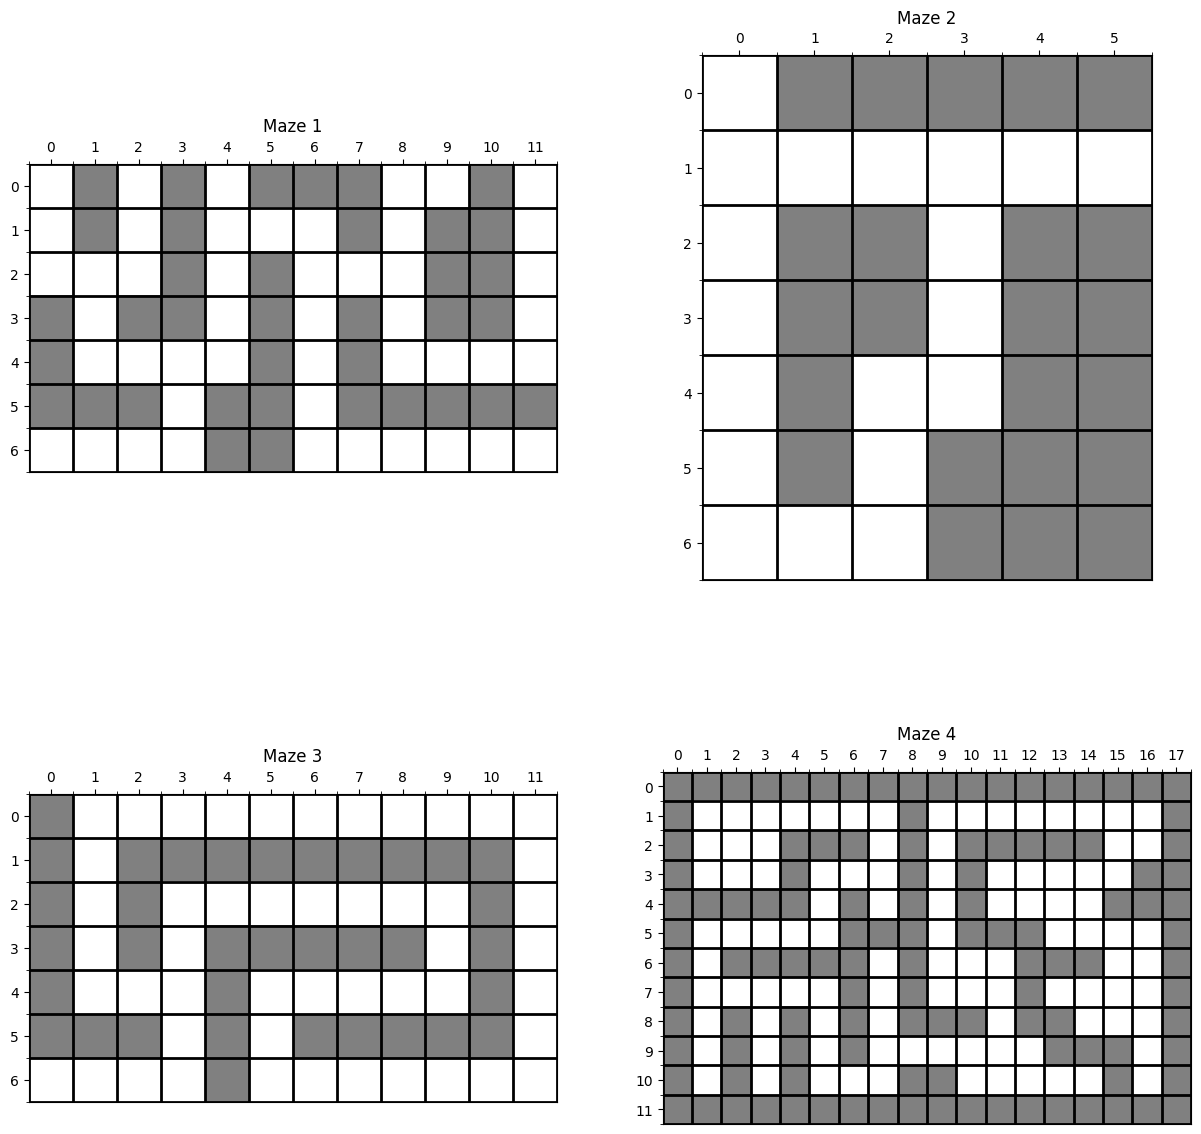

In [4]:
fig = plt.figure(figsize=(15,15))
rows = 2; cols = 2

for maze_num in range(1, len(maze_dict)+1):
    fig.add_subplot(rows, cols, maze_num)
    maze_plotter(maze_dict[f'maze_0{maze_num}'])
    plt.title(f'Maze {maze_num}')

**E1.03 & E1.04 :** Implement BFS (Breathe First Search) and DFS (Depth First Search) as a single algorithm
- Display visited states registered at $Q$
- Visually color states visited
- Algorithm is able to receive a Stack and Queue as $Q$

*Support Functions*  
**f(x,u)** -> Get state $x'$ after executing action $u$ in state $x$  
**U(x)** -> Get valid action space respecting state $x$  
**get_index()** -> Maps state to maze index

In [96]:
"""
Agent Actions (Clockwise):
- Up : (x-1, y)
- Right : (x, y+1)
- Down : (x+1, y)
- Left : (x, y-1)
"""

def f(x: tuple, u: tuple):
    return tuple(np.add(x,u))

def U(state: tuple, maze_dim: tuple) -> np.ndarray:
    U = []
    if not (state[0] - 1 < 0): U.append((-1,0))               # Move Up
    if not (state[1] + 1 > maze_dim[1] - 1): U.append((0,1))  # Move Right
    if not (state[0] + 1 > maze_dim[0] - 1): U.append((1,0))  # Move Down
    if not (state[1] - 1 < 0): U.append((0,-1))               # Move Left
    return np.array(U)
  
def get_index(state: tuple, maze_dim: tuple):
    return (state[0] * (maze_dim[1])) + state[1]

In [97]:
def BDFS(Q: Union[Stack, Queue], init_x: tuple, target_x: tuple, maze_data: np.ndarray) -> np.ndarray:
    # Dict that contains maze information
    mi = {
        'maze_dim': maze_data.shape,        # Calculate maze index and Set maze constraints
        'status': False,                    # Tells whether target_x has a solution
        'visited_x': [],                    # Stores visited states
        'visited_m':np.copy(maze_data)}     # Maze copy to mark visited states

    # Either init or target state is a forbidden cell
    if maze_data[init_x[0],init_x[1]] or maze_data[target_x[0],target_x[1]] == 1:
        return mi

    # BDFS Start
    Q.insert(init_x); mi['visited_m'].put(get_index(init_x, mi['maze_dim']), 2)
    mi['visited_x'].append(init_x) 

    # Border has valid states
    while Q.size() != 0:
        # Get Current State 
        x = Q.get_first()
        
        # Current state matches target state | SUCCESS
        if x[0] == target_x[0] and x[1] == target_x[1]:
            mi['status'] = True; return mi
        
        # Explores action space
        for u in U(x, mi['maze_dim']):
            next_x = f(x,u)
            if mi['visited_m'][next_x[0],next_x[1]] == 2: continue
            elif mi['visited_m'][next_x[0],next_x[1]] == 0:
                mi['visited_m'].put(get_index(next_x, mi['maze_dim']), 2)
                mi['visited_x'].append(next_x) 
                Q.insert(next_x)

    # Border doesn't have any valid state | FAILURE
    return mi 

#### Side-by-Side Comparison: BFS and DFS on Maze 2

Maze 02 has solution to target state? : True
Visited States at Q :
(6, 0), (5, 0), (6, 1), (4, 0)
(6, 2), (3, 0), (5, 2), (2, 0)
(4, 2), (1, 0), (4, 3), (0, 0)
(1, 1), (3, 3), (1, 2), 

Maze 02 has solution to target state? : True
Visited States at Q :
(6, 0), (5, 0), (6, 1), (6, 2)
(5, 2), (4, 2), (4, 3), (3, 3)




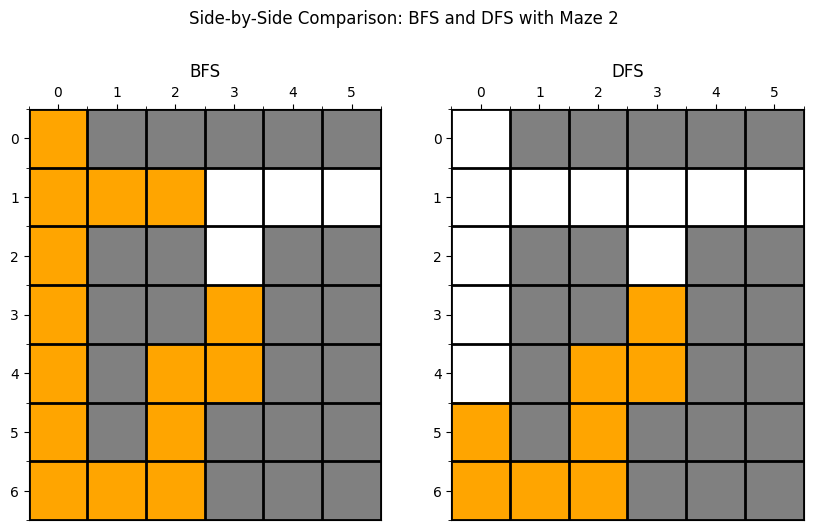

In [108]:
borders = [Queue(), Stack()]
fig = plt.figure(figsize=(10,10))
fig.suptitle("Side-by-Side Comparison: BFS and DFS with Maze 2", y=0.8)
rows = 1; cols = 2

for idx, dsa in enumerate(borders, start=1):
    fig.add_subplot(rows, cols, idx)
    maze_info = BDFS(dsa, (6,0), (3,3), maze_dict['maze_02'])
    print(f"Maze 02 has solution to target state? : {maze_info['status']}")
    print(f"Visited States at Q :")
    [print(maze_info['visited_x'][x], end=" ") if (x+1)%4 else print(maze_info['visited_x'][x]) for x in range(len(maze_info['visited_x']))]; print("\n")
    maze_plotter(maze_info['visited_m'])
    plt.title("DFS" if type(dsa) == Stack else "BFS")

#### Row-by-Row Comparison: BFS and DFS on All Mazes

BFS
Maze 01 has solution to target state? : True
Visited States at Q :
(6, 1) (6, 2) (6, 0) (6, 3) (5, 3) (4, 3) (4, 4) (4, 2)
(3, 4) (4, 1) (2, 4) (3, 1) (1, 4) 

Maze 02 has solution to target state? : False
Visited States at Q :


Maze 03 has solution to target state? : True
Visited States at Q :
(6, 1) (6, 2) (6, 0) (6, 3) (5, 3) (4, 3) (3, 3) (4, 2)
(2, 3) (4, 1) (2, 4) (3, 1) (2, 5) 

Maze 04 has solution to target state? : True
Visited States at Q :
(6, 1) (5, 1) (7, 1) (5, 2) (7, 2) (8, 1) (5, 3) (7, 3)
(9, 1) (5, 4) (7, 4) (8, 3) (10, 1) (5, 5) (7, 5) (9, 3)
(4, 5) (8, 5) (10, 3) (3, 5) (9, 5) (3, 6) (10, 5) (3, 7)
(10, 6) (2, 7) (4, 7) (10, 7) (1, 7) (9, 7) (1, 6) (8, 7)
(9, 8) (1, 5) (7, 7) (9, 9) (1, 4) (6, 7) (9, 10) (1, 3)
(9, 11) (10, 10) (2, 3) (1, 2) (8, 11) (9, 12) (10, 11) (3, 3)
(2, 2) (1, 1) (7, 11) (10, 12) (3, 2) (2, 1) (6, 11) (7, 10)
(10, 13) (3, 1) (6, 10) (7, 9) (10, 14) 

DFS
Maze 01 has solution to target state? : True
Visited States at Q :
(6, 1) (6, 2) (6

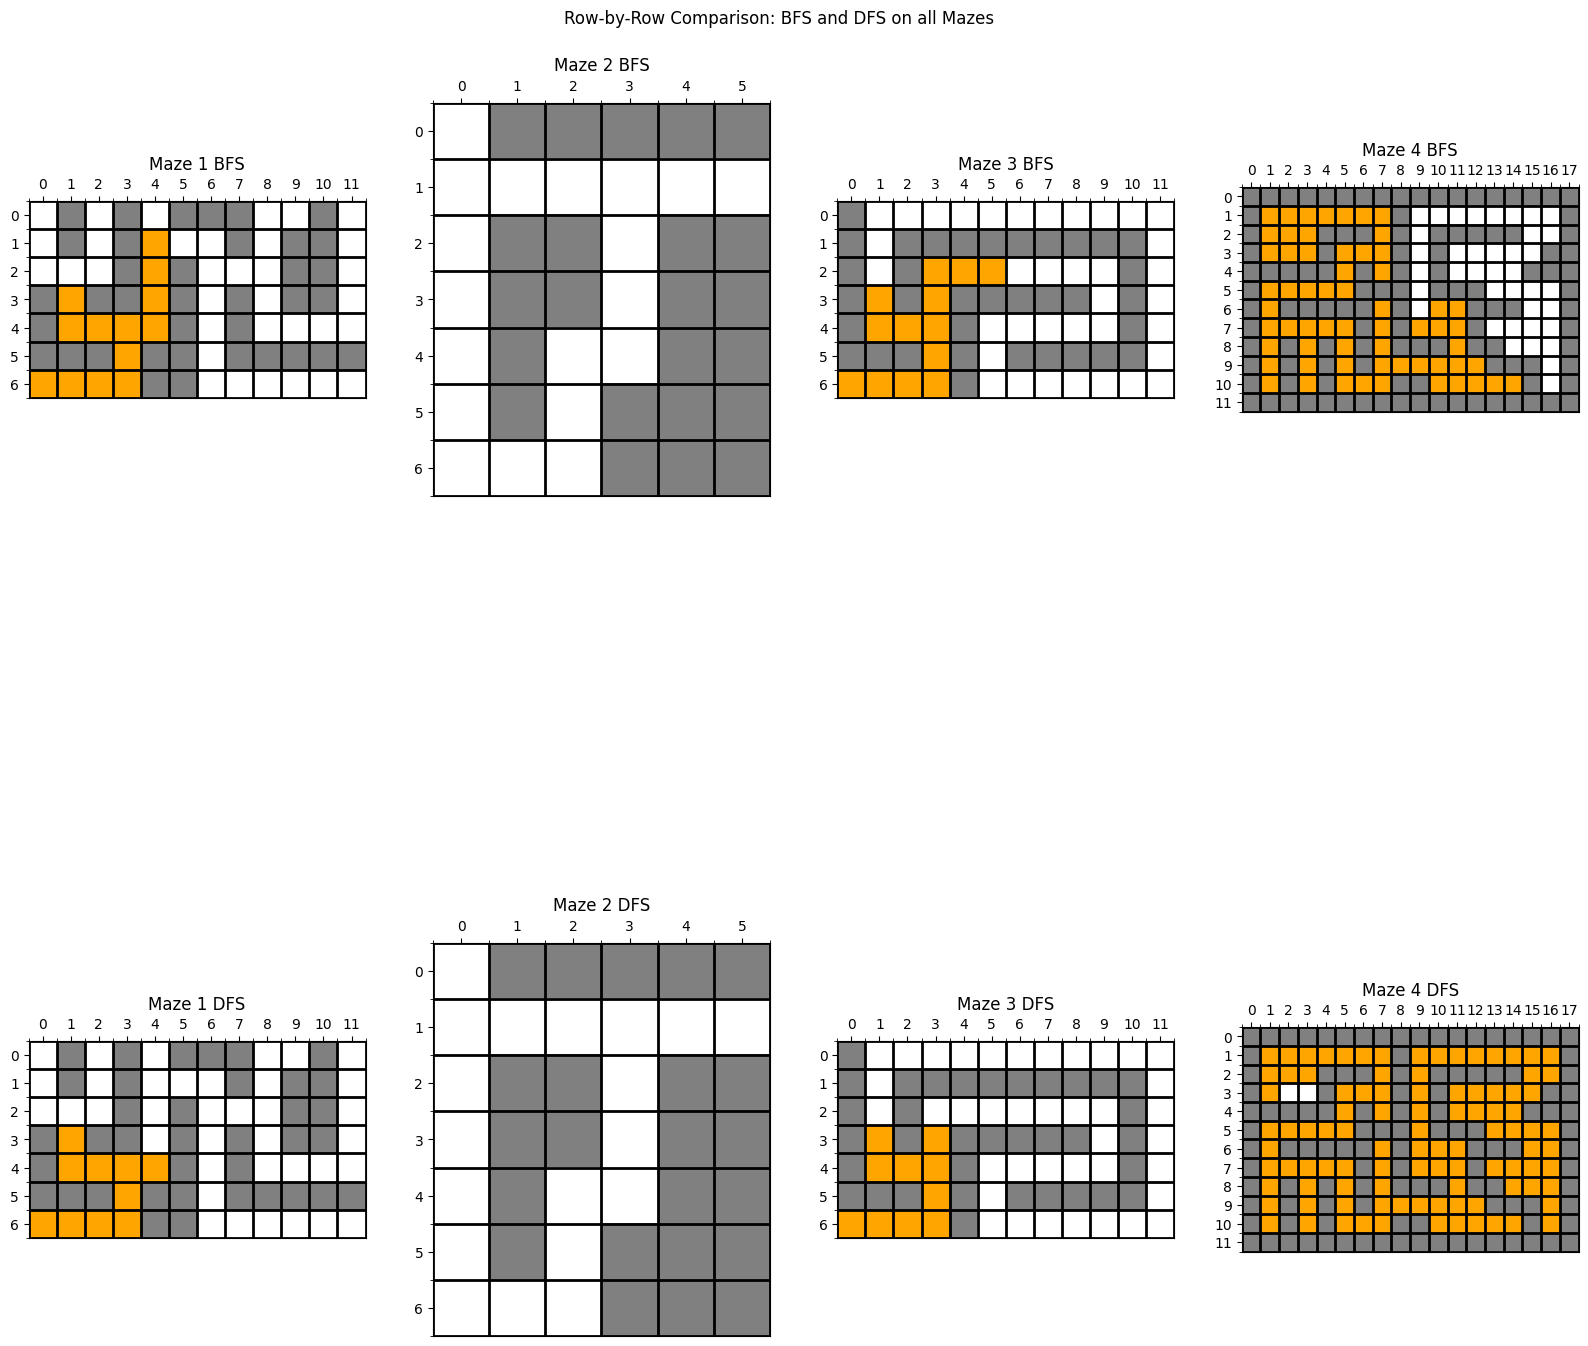

In [113]:
fig = plt.figure(figsize=(20,20))
rows = 2; cols = 4; counter = 1
init_state = (6,1); target_state = (3,1)
fig.suptitle("Row-by-Row Comparison: BFS and DFS on all Mazes", y=0.85)

for dsa in borders:
    print("\033[1mDFS\033[0m") if type(dsa) == Stack else print("\033[1mBFS\033[0m") 
    for maze_num in range(1, len(maze_dict)+1):
        fig.add_subplot(rows, cols, counter)
        if type(dsa) == Stack: q = Stack(); 
        else: q = Queue()
        mi = BDFS(q, init_state, target_state, maze_dict[f'maze_0{maze_num}'])
        print(f"Maze 0{maze_num} has solution to target state? : {mi['status']}")
        print(f"Visited States at Q :")
        [print(mi['visited_x'][x], end=" ") if (x+1)%8 else print(mi['visited_x'][x]) for x in range(len(mi['visited_x']))]; print("\n")
        maze_plotter(mi['visited_m'])
        plt.title(f"Maze {maze_num} DFS" if type(dsa) == Stack else f"Maze {maze_num} BFS")
        counter += 1
